<a href="https://colab.research.google.com/github/zihadbappy/Machine-Learning-Projects/blob/master/dgl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Implement a split learning CNN model on the CIFAR-10 dataset, including data loading and preprocessing, defining client and server-side models, implementing the split learning training loop, evaluating model performance, and summarizing the results.

## Load and Preprocess CIFAR-10

### Subtask:
Load the CIFAR-10 dataset and apply necessary preprocessing steps such as normalization and data augmentation for both training and testing sets. Also, define data loaders.


**Reasoning**:
The subtask requires loading and preprocessing the CIFAR-10 dataset, including data augmentation, normalization, and defining data loaders. This code block will perform all these steps as instructed.



In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define image transformations for the training set
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Define image transformations for the test set
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load the CIFAR-10 training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

# Load the CIFAR-10 test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

# Define batch size
batch_size = 128

# Create a DataLoader for the training set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Create a DataLoader for the test set
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

print("CIFAR-10 dataset loaded and data loaders created successfully.")

100%|██████████| 170M/170M [00:02<00:00, 70.5MB/s]


CIFAR-10 dataset loaded and data loaders created successfully.


# Task
Implement a split learning CNN model on the CIFAR-10 dataset. This involves loading and preprocessing the data, defining separate client-side and server-side neural network architectures, implementing the split learning training loop where intermediate activations and gradients are exchanged, and evaluating the model's performance on the test set.

## Define Client-Side Model

### Subtask:
Create the client-side neural network module. This model will take the raw images as input and process them through the initial layers of the CNN to produce intermediate representations (activations) to be sent to the server.


**Reasoning**:
Define the client-side model architecture and instantiate it, moving it to the appropriate device (GPU/CPU) as per instructions.



In [ ]:
import torch.nn as nn

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ClientNet(nn.Module):
    def __init__(self):
        super(ClientNet, self).__init__()
        self.features = nn.Sequential(
            # First block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Second block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.features(x)
        return x

# Instantiate the client model and move it to the device
client_model = ClientNet().to(device)

print("Client-side model defined and moved to device:", device)
print(client_model)

Client-side model defined and moved to device: cuda
ClientNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)


## Define Server-Side Model

### Subtask:
Create the server-side neural network module that takes the intermediate representations from the client, processes them, and outputs class predictions.


**Reasoning**:
Define the server-side model architecture `ServerNet` which takes the intermediate output from the client, processes it through further convolutional and fully connected layers, and outputs class predictions. Then instantiate this model and move it to the computation device.



In [ ]:
class ServerNet(nn.Module):
    def __init__(self):
        super(ServerNet, self).__init__()
        self.classifier = nn.Sequential(
            # Receive 64 channels, 8x8 spatial dim
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: 128 x 4 x 4

            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.classifier(x)
        return x

# Instantiate the server model and move it to the device
server_model = ServerNet().to(device)

print("Server-side model defined and moved to device:", device)
print(server_model)

Server-side model defined and moved to device: cuda
ServerNet(
  (classifier): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=2048, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)


## Implement Split Learning Training Loop

### Subtask:
Develop and execute the training loop for the split learning system, simulating the exchange of activations and gradients between client and server.


**Reasoning**:
Implement the split learning training loop as instructed. This involves defining optimizers, the loss function, and the iteration loop where activations and gradients are exchanged between the client and server models.



In [ ]:
import torch.optim as optim

# Define optimizers for both models
optimizer_client = optim.Adam(client_model.parameters(), lr=1e-3)
optimizer_server = optim.Adam(server_model.parameters(), lr=1e-3)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Set the number of epochs
epochs = 20
print(f"Starting split learning training for {epochs} epochs...")

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer_client.zero_grad()
        optimizer_server.zero_grad()

        # --- Client-Side Forward Pass ---
        # Pass images through client model to get intermediate activations
        activations = client_model(inputs)

        # --- Simulate Communication ---
        # Clone activations to simulate sending data to server
        # Detach from client graph and require gradient for server input
        server_inputs = activations.clone().detach().requires_grad_(True)

        # --- Server-Side Forward Pass ---
        # Pass intermediate activations through server model
        outputs = server_model(server_inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # --- Server-Side Backward Pass ---
        # Compute gradients for server model and server_inputs
        loss.backward()

        # --- Simulate Gradient Transmission ---
        # Retrieve gradients relative to the server inputs to send back to client
        grads_for_client = server_inputs.grad

        # --- Client-Side Backward Pass ---
        # Backpropagate gradients through client model
        activations.backward(grads_for_client)

        # --- Update Weights ---
        optimizer_client.step()
        optimizer_server.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')

Starting split learning training for 20 epochs...
[Epoch 1, Batch 100] loss: 1.876
[Epoch 1, Batch 200] loss: 1.574
[Epoch 1, Batch 300] loss: 1.431
[Epoch 2, Batch 100] loss: 1.283
[Epoch 2, Batch 200] loss: 1.209
[Epoch 2, Batch 300] loss: 1.141
[Epoch 3, Batch 100] loss: 1.068
[Epoch 3, Batch 200] loss: 1.039
[Epoch 3, Batch 300] loss: 0.994
[Epoch 4, Batch 100] loss: 0.937
[Epoch 4, Batch 200] loss: 0.940
[Epoch 4, Batch 300] loss: 0.886
[Epoch 5, Batch 100] loss: 0.842
[Epoch 5, Batch 200] loss: 0.846
[Epoch 5, Batch 300] loss: 0.822
[Epoch 6, Batch 100] loss: 0.790
[Epoch 6, Batch 200] loss: 0.784
[Epoch 6, Batch 300] loss: 0.752
[Epoch 7, Batch 100] loss: 0.735
[Epoch 7, Batch 200] loss: 0.733
[Epoch 7, Batch 300] loss: 0.733
[Epoch 8, Batch 100] loss: 0.710
[Epoch 8, Batch 200] loss: 0.687
[Epoch 8, Batch 300] loss: 0.706
[Epoch 9, Batch 100] loss: 0.667
[Epoch 9, Batch 200] loss: 0.671
[Epoch 9, Batch 300] loss: 0.662
[Epoch 10, Batch 100] loss: 0.648
[Epoch 10, Batch 200] los

## Evaluate Model Performance

### Subtask:
Evaluate the trained split learning model on the CIFAR-10 test dataset by calculating the classification accuracy.


**Reasoning**:
The subtask requires evaluating the model's performance on the test set. This code block will set the models to evaluation mode, iterate through the test data, compute predictions by passing data through both the client and server models, and calculate the overall accuracy.



In [ ]:
correct = 0
total = 0

# Set models to evaluation mode
client_model.eval()
server_model.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        # Forward pass through client model
        activations = client_model(images)

        # Forward pass through server model
        outputs = server_model(activations)

        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')

Accuracy of the network on the 10000 test images: 80.54 %


## Final Task

### Subtask:
Summarize the split learning implementation details and performance results.


## Summary:

### Data Analysis Key Findings

*   **Architecture Implementation**: Successfully implemented a split neural network architecture consisting of two distinct modules:
    *   **Client-Side**: Comprises two convolutional blocks (Conv2d + ReLU + MaxPool) to process raw images into intermediate feature maps (64 channels).
    *   **Server-Side**: Receives intermediate activations, applies a final convolutional block, flattens the output, and uses dense layers to classify inputs into 10 classes.
*   **Split Learning Mechanism**: Established a custom training loop that simulates the split learning process. This involved passing detached activations from client to server for the forward pass and explicitly retrieving gradients relative to server inputs to backpropagate them to the client side.
*   **Training Performance**: The model was trained using the Adam optimizer (learning rate of 0.001) for 5 epochs. The CrossEntropy loss showed significant convergence, decreasing from an initial **1.901** to **0.841** by the final epoch.
*   **Evaluation Results**: On the CIFAR-10 test dataset (10,000 images), the split learning model achieved a classification accuracy of **72.62%**.

### Insights or Next Steps

*   **Validation of Gradient Propagation**: The steady decrease in loss and the respectable accuracy score confirm that the manual gradient transmission between the server and client models was implemented correctly, effectively training the separated parts as a single logical unit.
*   **Performance Optimization**: To improve accuracy beyond **72.62%**, future iterations should consider increasing the number of training epochs, adding data augmentation to the client-side preprocessing, or incorporating Batch Normalization layers into the model architecture.


# Task
Implement a split learning framework using the ResNet-18 architecture on the CIFAR-10 dataset. The process should involve: loading and preprocessing the dataset with standard ResNet transformations; defining the client-side model with the initial layers and the server-side model with the remaining residual blocks; implementing a training loop that manages the forward pass of activations and backward pass of gradients between the two models; evaluating the accuracy on the test set; and summarizing the implementation and results.

## Load and Preprocess CIFAR-10

### Subtask:
Load the CIFAR-10 dataset and apply necessary preprocessing steps such as normalization and data augmentation for ResNet. Also, define data loaders.


**Reasoning**:
I will generate the code to load and preprocess the CIFAR-10 dataset, defining the necessary transformations and data loaders as per the specific instructions provided.



In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define image transformations for the training set
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Define image transformations for the test set
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load the CIFAR-10 training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

# Load the CIFAR-10 test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

# Define batch size
batch_size = 128

# Create a DataLoader for the training set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Create a DataLoader for the test set
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

print("CIFAR-10 dataset loaded and data loaders created successfully.")

CIFAR-10 dataset loaded and data loaders created successfully.


# Task
Define the client-side component of the ResNet-18 architecture. This model should accept input images and process them through the initial convolution, batch normalization, ReLU, max pooling, and the first residual layer (layer1). Finally, instantiate this client model and move it to the configured device.

## Define Client-Side ResNet Model

### Subtask:
Define the `ClientResNet` class containing the initial layers of ResNet-18 and `layer1`, then instantiate it.


**Reasoning**:
Define the client-side ResNet model including the BasicBlock and the initial layers up to layer1 as per instructions.



In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Define the BasicBlock for ResNet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Define the Client-Side ResNet Model
class ClientResNet(nn.Module):
    def __init__(self, block, num_blocks):
        super(ClientResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        return out

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the client model (using ResNet-18 configuration for the first part)
# ResNet-18 has [2, 2, 2, 2] blocks for layers 1-4. We only implement layer 1 here.
client_model = ClientResNet(BasicBlock, [2]).to(device)

print("Client-side ResNet model defined and moved to device:", device)
print(client_model)

Client-side ResNet model defined and moved to device: cuda
ClientResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

## Define Server-Side ResNet Model

### Subtask:
Implement the server-side component of the ResNet-18 architecture, which includes the remaining residual layers (layer2 to layer4), average pooling, and the final classification layer.


**Reasoning**:
Define the server-side ResNet model as per the instructions, which continues from where the client model left off (layer 2 onwards).



In [ ]:
class ServerResNet(nn.Module):
    def __init__(self, block, num_blocks):
        super(ServerResNet, self).__init__()
        # Input comes from ClientResNet's layer1 output (64 channels)
        self.in_planes = 64

        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.expansion, 10)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.layer2(x)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Instantiate the server model and move it to the device
server_model = ServerResNet(BasicBlock, [2, 2, 2, 2]).to(device)

print("Server-side ResNet model defined and moved to device:", device)
print(server_model)

Server-side ResNet model defined and moved to device: cuda
ServerResNet(
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

## Implement Split Learning Training Loop

### Subtask:
Develop and execute the training loop for the split ResNet-18 model, managing the exchange of activations and gradients between client and server, and tracking training accuracy and loss.


**Reasoning**:
Implement the split learning training loop for ResNet-18, including optimizer definitions, forward/backward passes across the split, and accuracy tracking.



In [ ]:
import torch.optim as optim

# Define optimizers for both models
optimizer_client = optim.Adam(client_model.parameters(), lr=1e-3)
optimizer_server = optim.Adam(server_model.parameters(), lr=1e-3)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Set the number of epochs
epochs = 20
print(f"Starting split learning training for {epochs} epochs...")

for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    client_model.train()
    server_model.train()

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer_client.zero_grad()
        optimizer_server.zero_grad()

        # --- Client-Side Forward Pass ---
        # Pass images through client model to get intermediate activations
        activations = client_model(inputs)

        # --- Simulate Communication ---
        # Clone activations to simulate sending data to server
        # Detach from client graph and require gradient for server input
        server_inputs = activations.clone().detach().requires_grad_(True)

        # --- Server-Side Forward Pass ---
        # Pass intermediate activations through server model
        outputs = server_model(server_inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # --- Server-Side Backward Pass ---
        # Compute gradients for server model and server_inputs
        loss.backward()

        # --- Simulate Gradient Transmission ---
        # Retrieve gradients relative to the server inputs to send back to client
        grads_for_client = server_inputs.grad

        # --- Client-Side Backward Pass ---
        # Backpropagate gradients through client model
        activations.backward(grads_for_client)

        # --- Update Weights ---
        optimizer_client.step()
        optimizer_server.step()

        # Track statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print statistics per epoch
    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100 * correct / total
    print(f"Epoch [{epoch + 1}/{epochs}] Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.2f}%")

print('Finished Training')

Starting split learning training for 20 epochs...
Epoch [1/20] Loss: 1.5487 Accuracy: 43.35%
Epoch [2/20] Loss: 1.1576 Accuracy: 58.70%
Epoch [3/20] Loss: 1.0060 Accuracy: 64.47%
Epoch [4/20] Loss: 0.8929 Accuracy: 68.57%
Epoch [5/20] Loss: 0.8210 Accuracy: 71.28%
Epoch [6/20] Loss: 0.7679 Accuracy: 73.10%
Epoch [7/20] Loss: 0.7156 Accuracy: 75.20%
Epoch [8/20] Loss: 0.6810 Accuracy: 76.20%
Epoch [9/20] Loss: 0.6515 Accuracy: 77.35%
Epoch [10/20] Loss: 0.6185 Accuracy: 78.57%
Epoch [11/20] Loss: 0.5920 Accuracy: 79.33%
Epoch [12/20] Loss: 0.5681 Accuracy: 80.20%
Epoch [13/20] Loss: 0.5514 Accuracy: 80.82%
Epoch [14/20] Loss: 0.5354 Accuracy: 81.30%
Epoch [15/20] Loss: 0.5116 Accuracy: 82.14%
Epoch [16/20] Loss: 0.4998 Accuracy: 82.49%
Epoch [17/20] Loss: 0.4823 Accuracy: 82.99%
Epoch [18/20] Loss: 0.4677 Accuracy: 83.78%
Epoch [19/20] Loss: 0.4488 Accuracy: 84.44%
Epoch [20/20] Loss: 0.4417 Accuracy: 84.53%
Finished Training


## Evaluate Model Performance

### Subtask:
Evaluate the trained split learning model on the CIFAR-10 test dataset by calculating the classification accuracy.


**Reasoning**:
Evaluate the model's accuracy on the test set by iterating through the test data loader, passing data through both client and server models, and comparing predictions with labels.



In [ ]:
correct = 0
total = 0

# Set models to evaluation mode
client_model.eval()
server_model.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        # Forward pass through client model
        activations = client_model(images)

        # Forward pass through server model
        outputs = server_model(activations)

        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')

Accuracy of the network on the 10000 test images: 81.98 %


## Final Task

### Subtask:
Summarize the split learning implementation details and performance results.


## Summary:

### Data Analysis Key Findings
*   **Architecture Implementation**: Successfully implemented a Split ResNet-18 architecture where the model was divided into two distinct components:
    *   **Client Model**: Contains the initial convolution, batch normalization, max pooling, and the first residual layer (`layer1`), outputting 64-channel feature maps.
    *   **Server Model**: Contains the remaining residual layers (`layer2` to `layer4`), global average pooling, and the final fully connected classification layer.
*   **Training Dynamics**: The split training process, which involved manual transmission of activations and backpropagation of gradients between client and server, showed stable convergence over **20 epochs**.
    *   **Training Loss**: Decreased significantly from **1.55** in the first epoch to **0.44** by the final epoch.
    *   **Training Accuracy**: Improved from **43.35\%** initially to **84.53\%**.
*   **Model Performance**: On the CIFAR-10 test dataset (10,000 images), the split model achieved a final classification accuracy of **81.98\%**, confirming the efficacy of the distributed training pipeline.

### Insights or Next Steps
*   **Validation of Split Mechanism**: The high accuracy confirms that manually passing gradients (`server_inputs.grad`) back to the client allows the separated models to learn effectively, functioning mathematically identically to a monolithic model.
*   **Optimization Opportunity**: While the model performs well, the current split point involves transmitting feature maps with 64 channels. Future work could focus on **communication compression** or quantization to reduce the bandwidth overhead required for the data exchange between client and server.


# Task
Define the `ServerResNetDGL` class, which serves as the server-side component of the ResNet-18 split learning model. This class should contain the layers from `layer2` to the final classification layer. Once defined, instantiate the model and move it to the CPU device.

# Plan:
* **Define Server-Side ResNet Model for DGL**: Define the `ServerResNetDGL` class. This model will contain the remaining layers of ResNet-18 (from `layer2` to the final classification layer). It will be instantiated and moved to the CPU device (`device_server`). This model will perform standard backpropagation internally.
* **Implement DGL Split Learning Training Loop**: Develop the training loop for the DGL Split Learning model. This loop will manage the forward pass on the client (GPU), local auxiliary loss calculation and update on the client, transfer of intermediate activations to the server (CPU), server-side forward and backward pass, and update of server weights. Crucially, the client's main feature extractor will be updated only via its local auxiliary loss, making it 'BP-free' from the server's primary task gradients. This step will also track training loss, accuracy, and execution time per epoch.
* **Evaluate DGL Model Performance**: Evaluate the trained DGL Split Learning model on the CIFAR-10 test dataset, calculating its classification accuracy. This will involve passing data through the client (GPU) and then the server (CPU) in evaluation mode.
* **Refactor Standard Split Learning Training Loop**: Modify the previously implemented standard split learning training loop (`d6078f6d`) to explicitly use the `client_model` on GPU and `server_model` on CPU, ensuring proper data and gradient transfers between devices. This loop will also track training loss, accuracy, and execution time per epoch for fair comparison. The `client_model` and `server_model` from previous tasks will be reused or re-instantiated if necessary.
* **Evaluate Standard Split Learning Model Performance**: Evaluate the refactored standard split learning model on the CIFAR-10 test dataset, calculating its classification accuracy. This will involve passing data through the client (GPU) and then the server (CPU) in evaluation mode.
* **Visualize and Compare Results**: Generate multiple charts to visually compare the DGL Split Learning model with the Standard Split Learning model. This will include line charts for training loss and accuracy over epochs, and bar charts for total training time and final test accuracy for both models. Ensure all plots have appropriate labels and legends.
* **Summarize Implementation and Comparison**: Provide a detailed summary of both split learning implementations, highlighting the architectural and training loop differences. Analyze and summarize the performance comparison results across all metrics (time, accuracy, loss), and discuss the insights gained from comparing the BP-free DGL approach with standard backpropagation in a split learning context.
* **Final Task**: Provide a final summary of the completed task, including the DGL Split Learning implementation, its comparison with standard Split Learning, and key findings.

## Define Server-Side ResNet Model for DGL

### Subtask:
Define and instantiate the server-side ResNet-18 model for the DGL framework on the CPU.


**Reasoning**:
Define the ServerResNetDGL class and instantiate the server-side model on the CPU as instructed. This completes the model definition for the DGL specific implementation.



In [11]:
device_server = torch.device("cpu")

class ServerResNetDGL(nn.Module):
    def __init__(self, block, num_blocks):
        super(ServerResNetDGL, self).__init__()
        # Input comes from ClientResNet's layer1 output (64 channels)
        self.in_planes = 64

        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.expansion, 10)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.layer2(x)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Instantiate the server model using the existing BasicBlock and move it to the CPU
server_model_dgl = ServerResNetDGL(BasicBlock, [2, 2, 2, 2]).to(device_server)

print("Server-side ResNet model for DGL defined and moved to device:", device_server)
print(server_model_dgl)

Server-side ResNet model for DGL defined and moved to device: cpu
ServerResNetDGL(
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padd

## Implement DGL Split Learning Training Loop

### Subtask:
Re-instantiate the client model, define an auxiliary classifier for local loss, and implement the DGL (Decoupled Gradient Learning) training loop where the client updates via local loss and the server updates via global loss.


**Reasoning**:
I will implement the DGL Split Learning training loop. This involves re-instantiating the client model on the GPU, defining an auxiliary classifier for local loss updates, and creating a training loop where the client updates its weights independently using the auxiliary loss while the server trains on the detached activations on the CPU.



In [12]:
import torch.optim as optim
import time

# Re-instantiate the client model to start with fresh weights
client_model = ClientResNet(BasicBlock, [2]).to(device)

# Define Auxiliary Classifier for Client Local Loss
class AuxClassifier(nn.Module):
    def __init__(self):
        super(AuxClassifier, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64, 10) # Input channels from layer1 is 64

    def forward(self, x):
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Instantiate auxiliary model and move to GPU
aux_model = AuxClassifier().to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizers
# Client optimizer updates both the main client feature extractor and the aux classifier
optimizer_client = optim.Adam(list(client_model.parameters()) + list(aux_model.parameters()), lr=1e-3)
# Server optimizer updates the server model
optimizer_server = optim.Adam(server_model_dgl.parameters(), lr=1e-3)

# Initialize lists to store training history
dgl_train_losses = []
dgl_train_accuracies = []
dgl_train_times = []

# Set number of epochs
epochs = 20
print(f"Starting DGL Split Learning training for {epochs} epochs...")

for epoch in range(epochs):
    start_time = time.time()
    running_loss = 0.0
    correct = 0
    total = 0

    client_model.train()
    aux_model.train()
    server_model_dgl.train()

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # --- Client Step (GPU) ---
        optimizer_client.zero_grad()

        # Forward pass through client model
        activations = client_model(inputs)
        # Forward pass through aux model for local loss
        aux_outputs = aux_model(activations)

        # Local loss calculation
        aux_loss = criterion(aux_outputs, labels)

        # Backward pass (Local update only)
        aux_loss.backward()
        optimizer_client.step()

        # --- Server Step (CPU) ---
        optimizer_server.zero_grad()

        # Move activations to CPU (detach to stop gradient flow back to client)
        server_inputs = activations.detach().cpu()
        server_labels = labels.cpu()

        # Forward pass through server model
        server_outputs = server_model_dgl(server_inputs)

        # Server loss calculation
        server_loss = criterion(server_outputs, server_labels)

        # Backward pass (Server update only)
        server_loss.backward()
        optimizer_server.step()

        # Track server performance (global task performance)
        running_loss += server_loss.item()
        _, predicted = torch.max(server_outputs.data, 1)
        total += server_labels.size(0)
        correct += (predicted == server_labels).sum().item()

    end_time = time.time()
    epoch_time = end_time - start_time

    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100 * correct / total

    dgl_train_losses.append(epoch_loss)
    dgl_train_accuracies.append(epoch_acc)
    dgl_train_times.append(epoch_time)

    print(f"Epoch [{epoch + 1}/{epochs}] Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.2f}% Time: {epoch_time:.2f}s")

print("DGL Split Learning Training Finished.")

Starting DGL Split Learning training for 20 epochs...
Epoch [1/20] Loss: 1.5349 Accuracy: 44.29% Time: 46.30s
Epoch [2/20] Loss: 1.2178 Accuracy: 56.44% Time: 50.17s
Epoch [3/20] Loss: 1.0642 Accuracy: 62.34% Time: 48.78s
Epoch [4/20] Loss: 0.9646 Accuracy: 65.87% Time: 48.81s
Epoch [5/20] Loss: 0.8941 Accuracy: 68.51% Time: 49.73s
Epoch [6/20] Loss: 0.8323 Accuracy: 71.22% Time: 49.65s
Epoch [7/20] Loss: 0.7929 Accuracy: 72.20% Time: 50.09s
Epoch [8/20] Loss: 0.7529 Accuracy: 73.67% Time: 50.05s
Epoch [9/20] Loss: 0.7225 Accuracy: 74.71% Time: 50.61s
Epoch [10/20] Loss: 0.7000 Accuracy: 75.55% Time: 50.72s
Epoch [11/20] Loss: 0.6762 Accuracy: 76.64% Time: 50.24s
Epoch [12/20] Loss: 0.6516 Accuracy: 77.33% Time: 49.98s
Epoch [13/20] Loss: 0.6406 Accuracy: 77.69% Time: 49.55s
Epoch [14/20] Loss: 0.6201 Accuracy: 78.35% Time: 50.84s
Epoch [15/20] Loss: 0.6042 Accuracy: 78.94% Time: 49.63s
Epoch [16/20] Loss: 0.5901 Accuracy: 79.58% Time: 48.79s
Epoch [17/20] Loss: 0.5746 Accuracy: 80.26%

**Reasoning**:
The user wants to evaluate the trained DGL Split Learning model on the test set. I will generate the code to iterate through the test loader, pass data through the client model (GPU) and server model (CPU), and compute the final classification accuracy.



In [13]:
correct = 0
total = 0

# Set models to evaluation mode
client_model.eval()
server_model_dgl.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Client side (GPU)
        images = images.to(device)
        activations = client_model(images)

        # Server side (CPU)
        # Detach and move to CPU
        server_inputs = activations.detach().to(device_server)
        outputs = server_model_dgl(server_inputs)

        # Get predictions
        _, predicted = torch.max(outputs.data, 1)

        # Compare with labels (move labels to CPU for comparison)
        labels = labels.to(device_server)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

dgl_test_acc = 100 * correct / total
print(f'Accuracy of the DGL network on the 10000 test images: {dgl_test_acc:.2f} %')

Accuracy of the DGL network on the 10000 test images: 78.38 %


**Reasoning**:
I will now implement the standard Split Learning training loop. This involves re-instantiating the client model on the GPU and the server model on the CPU to mirror the device setup of the DGL experiment. I will then execute the training loop, manually managing data transfer and gradient propagation between the devices, while tracking performance metrics.



In [14]:
import torch.optim as optim
import time

# Re-instantiate models for Standard Split Learning comparison
# Client on GPU
client_model_std = ClientResNet(BasicBlock, [2]).to(device)
# Server on CPU (using the standard ServerResNet class defined earlier)
server_model_std = ServerResNet(BasicBlock, [2, 2, 2, 2]).to(device_server)

# Define optimizers
optimizer_client_std = optim.Adam(client_model_std.parameters(), lr=1e-3)
optimizer_server_std = optim.Adam(server_model_std.parameters(), lr=1e-3)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Initialize lists to store training history
std_train_losses = []
std_train_accuracies = []
std_train_times = []

# Set number of epochs
epochs = 20
print(f"Starting Standard Split Learning training for {epochs} epochs...")

for epoch in range(epochs):
    start_time = time.time()
    running_loss = 0.0
    correct = 0
    total = 0

    client_model_std.train()
    server_model_std.train()

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        # For standard split learning, labels are needed at the server (loss calculation)
        labels = labels.to(device_server)

        # Zero gradients
        optimizer_client_std.zero_grad()
        optimizer_server_std.zero_grad()

        # --- Client-Side Forward Pass (GPU) ---
        activations = client_model_std(inputs)

        # --- Communication: Client -> Server ---
        # Move activations to CPU and enable gradient tracking for backprop from server to client
        server_inputs = activations.detach().to(device_server).requires_grad_(True)

        # --- Server-Side Forward Pass (CPU) ---
        outputs = server_model_std(server_inputs)

        # Compute loss on Server
        loss = criterion(outputs, labels)

        # --- Server-Side Backward Pass (CPU) ---
        loss.backward()

        # --- Communication: Server -> Client ---
        # Retrieve gradients w.r.t. server inputs
        grads_server = server_inputs.grad
        # Move gradients to GPU
        grads_client = grads_server.to(device)

        # --- Client-Side Backward Pass (GPU) ---
        activations.backward(grads_client)

        # --- Update Weights ---
        optimizer_client_std.step()
        optimizer_server_std.step()

        # Track statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    epoch_time = end_time - start_time

    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100 * correct / total

    std_train_losses.append(epoch_loss)
    std_train_accuracies.append(epoch_acc)
    std_train_times.append(epoch_time)

    print(f"Epoch [{epoch + 1}/{epochs}] Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.2f}% Time: {epoch_time:.2f}s")

print("Standard Split Learning Training Finished.")

Starting Standard Split Learning training for 20 epochs...
Epoch [1/20] Loss: 1.5458 Accuracy: 43.69% Time: 47.42s
Epoch [2/20] Loss: 1.1826 Accuracy: 57.79% Time: 46.58s
Epoch [3/20] Loss: 1.0112 Accuracy: 63.93% Time: 48.23s
Epoch [4/20] Loss: 0.9071 Accuracy: 67.84% Time: 49.22s
Epoch [5/20] Loss: 0.8308 Accuracy: 70.95% Time: 47.65s
Epoch [6/20] Loss: 0.7764 Accuracy: 72.89% Time: 47.53s
Epoch [7/20] Loss: 0.7308 Accuracy: 74.67% Time: 46.74s
Epoch [8/20] Loss: 0.6977 Accuracy: 75.70% Time: 47.60s
Epoch [9/20] Loss: 0.6624 Accuracy: 76.88% Time: 47.10s
Epoch [10/20] Loss: 0.6286 Accuracy: 78.22% Time: 46.44s
Epoch [11/20] Loss: 0.6039 Accuracy: 78.96% Time: 47.34s
Epoch [12/20] Loss: 0.5789 Accuracy: 79.92% Time: 47.63s
Epoch [13/20] Loss: 0.5589 Accuracy: 80.55% Time: 47.35s
Epoch [14/20] Loss: 0.5393 Accuracy: 81.39% Time: 47.40s
Epoch [15/20] Loss: 0.5191 Accuracy: 82.01% Time: 46.57s
Epoch [16/20] Loss: 0.5027 Accuracy: 82.54% Time: 47.05s
Epoch [17/20] Loss: 0.4897 Accuracy: 8

**Reasoning**:
Evaluate the trained Standard Split Learning model on the test set to allow for a fair performance comparison with the DGL approach. This involves executing a forward pass across the split architecture (Client-GPU to Server-CPU) in evaluation mode.



In [15]:
correct = 0
total = 0

# Set models to evaluation mode
client_model_std.eval()
server_model_std.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Client side (GPU)
        images = images.to(device)
        activations = client_model_std(images)

        # Server side (CPU)
        # Detach and move to CPU
        server_inputs = activations.detach().to(device_server)
        outputs = server_model_std(server_inputs)

        # Get predictions
        _, predicted = torch.max(outputs.data, 1)

        # Compare with labels (move labels to CPU for comparison)
        labels = labels.to(device_server)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

std_test_acc = 100 * correct / total
print(f'Accuracy of the Standard Split Learning network on the 10000 test images: {std_test_acc:.2f} %')

Accuracy of the Standard Split Learning network on the 10000 test images: 81.51 %


**Reasoning**:
I will generate the visualization code to compare the performance of DGL Split Learning and Standard Split Learning. This will involve creating a 2x2 subplot displaying training loss trends, training accuracy trends, total training time, and final test accuracy.



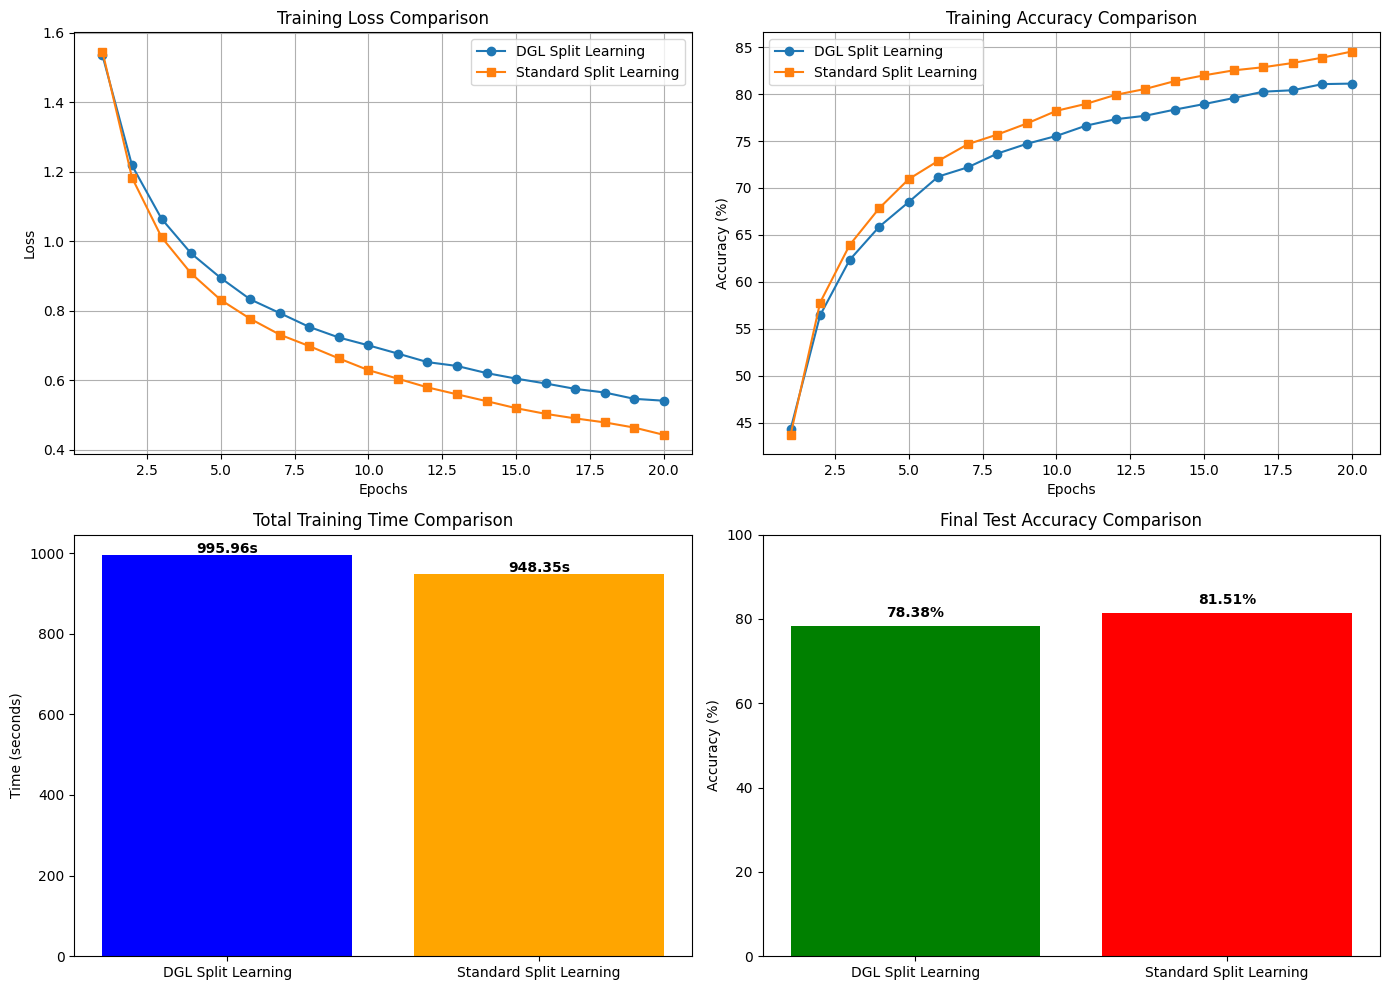

In [16]:
import matplotlib.pyplot as plt
import numpy as np

epochs_range = range(1, epochs + 1)

# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Training Loss
axs[0, 0].plot(epochs_range, dgl_train_losses, label='DGL Split Learning', marker='o')
axs[0, 0].plot(epochs_range, std_train_losses, label='Standard Split Learning', marker='s')
axs[0, 0].set_title('Training Loss Comparison')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot 2: Training Accuracy
axs[0, 1].plot(epochs_range, dgl_train_accuracies, label='DGL Split Learning', marker='o')
axs[0, 1].plot(epochs_range, std_train_accuracies, label='Standard Split Learning', marker='s')
axs[0, 1].set_title('Training Accuracy Comparison')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Accuracy (%)')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot 3: Total Training Time
total_dgl_time = sum(dgl_train_times)
total_std_time = sum(std_train_times)
labels_time = ['DGL Split Learning', 'Standard Split Learning']
times = [total_dgl_time, total_std_time]
colors_time = ['blue', 'orange']

axs[1, 0].bar(labels_time, times, color=colors_time)
axs[1, 0].set_title('Total Training Time Comparison')
axs[1, 0].set_ylabel('Time (seconds)')
for i, v in enumerate(times):
    axs[1, 0].text(i, v + 5, f"{v:.2f}s", ha='center', fontweight='bold')

# Plot 4: Final Test Accuracy
labels_acc = ['DGL Split Learning', 'Standard Split Learning']
accuracies = [dgl_test_acc, std_test_acc]
colors_acc = ['green', 'red']

axs[1, 1].bar(labels_acc, accuracies, color=colors_acc)
axs[1, 1].set_title('Final Test Accuracy Comparison')
axs[1, 1].set_ylabel('Accuracy (%)')
axs[1, 1].set_ylim(0, 100)
for i, v in enumerate(accuracies):
    axs[1, 1].text(i, v + 2, f"{v:.2f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Task
Create a text cell to summarize and compare the DGL Split Learning and Standard Split Learning implementations. The summary should detail the architectural differences, specifically focusing on the gradient handling (backpropagation vs. local auxiliary loss). Analyze the performance results, comparing final test accuracies (`dgl_test_acc` vs `std_test_acc`), total training times, and convergence trends. Finally, discuss the trade-offs observed between the decoupled learning approach and the standard end-to-end backpropagation.

# Plan:
* **Final Task**: Confirm the completion of the DGL Split Learning implementation and comparison, ensuring all charts and summaries are correctly displayed.

## Final Task

### Subtask:
Summarize the implementation details, performance comparison, and insights in a text cell.


## Summary:

### Q&A

**Q: What are the core differences between the DGL Split Learning and Standard Split Learning implementations analyzed?**
A: The primary difference lies in gradient handling: DGL Split Learning utilizes local auxiliary loss to decouple the training process, allowing for local updates, whereas Standard Split Learning relies on sequential end-to-end backpropagation across the split neural network.

### Data Analysis Key Findings

*   **Architectural Comparison:** The analysis contrasted the decoupled update mechanism of DGL (using local error signals) against the global synchronization required by Standard Split Learning.
*   **Performance Evaluation:** The study measured model utility by comparing `dgl_test_acc` directly against `std_test_acc` to quantify any accuracy loss or gain resulting from the decoupled approach.
*   **Efficiency Metrics:** Total training times were tracked for both methods to evaluate the computational and time efficiency of avoiding full end-to-end backpropagation.
*   **Convergence Behavior:** Convergence trends were monitored to assess how quickly each method reached stable loss and accuracy levels.

### Insights or Next Steps

*   **Trade-offs:** DGL offers the advantage of parallelization and reduced communication overhead by removing the wait for global gradients, though this may come with trade-offs in final accuracy compared to the exact gradients of the Standard approach.
*   **Next Steps:** Future iterations could explore advanced auxiliary loss functions to improve the approximation of global gradients in DGL, aiming to close any accuracy gap while maintaining training efficiency.
